# Dow Jones Technical Assignment

**Candidate Information**

- **Name:** Andrés Di Giovanni
- **Role:** Lead Data Scientist
- **Date:** 23/05/2025
- **Assignment:** NLP / IR / Gen AI / Semantic Search

**Objective**

The purpose of this assignment is to assess your skills in Natural Language Processing (NLP), Information Retrieval (IR), Generative AI, and Semantic Search. You will
need to source an open dataset, perform an in-depth analysis, build a model, and derive actionable insights.

**Assignment Description**

You are tasked with sourcing an open dataset related to textual data and using it to address a problem of your choice within the realm of NLP, IR, Gen AI, or Semantic Search. The focus can be on tasks such as text classification, summarization, topic modeling, question answering, media recommendations, or semantic search.

## 1. Dataset Overview

For this project, I use the **[Financial PhraseBank](https://huggingface.co/datasets/takala/financial_phrasebank)** dataset, a widely recognized benchmark for sentiment analysis in financial NLP tasks. It contains approximately 5,000 sentences extracted from English-language financial news, each labeled as:

* `positive`
* `neutral`
* `negative`

The annotations were performed by multiple individuals with finance and business backgrounds, ensuring domain-specific labeling quality. The dataset covers diverse topics such as earnings reports, M\&A activity, macroeconomic commentary, and leadership changes—making it well-suited for evaluating sentiment models in real-world financial contexts.

**Why this dataset?**

* **Domain alignment**: It directly reflects Dow Jones’ core business of financial media and market-sensitive news.
* **Task relevance**: Enables robust experimentation in sentiment classification, semantic understanding, and media recommendation based on tone.
* **Practicality**: The dataset is clean, well-annotated, and suitable for both classical and modern NLP techniques.
* **Business impact**: Financial sentiment analysis supports downstream applications such as market reaction modeling, investment decision-making, and risk analysis.

In short, this dataset provides a high-quality, domain-specific foundation to explore and benchmark NLP and semantic models in financial information retrieval.

## 2. Problem Definition

In financial markets, the sentiment conveyed in news articles and press releases plays a critical role in shaping investor behavior. Traders, analysts, and automated systems rely heavily on timely sentiment signals to interpret market direction and inform decision-making. However, the high volume of financial news and the nuanced language used present significant challenges for manual or generic NLP systems.

This project addresses the task of **financial sentiment classification**:

> Given a short financial phrase or headline, predict its sentiment as either *positive*, *neutral*, or *negative*.

**Why It Matters**

Even subtle shifts in language—e.g., *"profits declined slightly"* versus *"profits plummeted"*—can lead to materially different interpretations and market responses. Accurate sentiment classification enables:

* **Real-time signal extraction** for traders and risk teams
* **News filtering and alerting systems** tuned by sentiment
* **Tone-aware media recommendations** for clients and readers
* **Feature enrichment** for downstream predictive models, such as stock price movement forecasts

Generic sentiment models often struggle in the financial domain due to domain-specific jargon, formal tone, and the nuanced nature of financial writing. This makes domain-adapted solutions trained on curated datasets, such as the *Financial PhraseBank*, essential for high-stakes applications.

By solving this problem, we aim to build more intelligent and responsive tools for financial decision-making across media, investment, and risk management workflows.

## 3. Approach and Pipeline

To address the problem of financial sentiment classification, I developed a modular NLP pipeline that integrates both classical machine learning and transformer-based models. The design supports experimentation with various feature extraction methods, model architectures, and evaluation strategies.

**1. Tools and Frameworks**

The project leverages the following Python-based libraries and tools:

* **Python** – Core programming language
* **Pandas / NumPy** – Data manipulation and numerical operations
* **scikit-learn** – Preprocessing, classical models, metrics
* **Hugging Face Transformers / Datasets** – Pretrained models and dataset access
* **Optuna** – Hyperparameter optimization
* **XGBoost / Logistic Regression** – Classical classification algorithms
* **PyTorch** – Deep learning backend for transformer models
* **Matplotlib / Seaborn** – Visualizations and performance plotting
* **Transformers-Interpret** – Interpretability and token attribution for transformer models

**2. Pipeline Overview**

*Step 1: Data Loading and Exploration*

  * Dataset sourced from Hugging Face: [`takala/financial_phrasebank`](https://huggingface.co/datasets/takala/financial_phrasebank)
  * Exploratory analysis includes class distribution, sentence length statistics, and vocabulary frequency

*Step 2: Preprocessing*

  * Sentiment labels mapped to integers: `positive = 2`, `neutral = 1`, `negative = 0`
  * Stratified train/test split to maintain label distribution

*Step 3: Feature Engineering*

Two modeling tracks were implemented:

* *Track 1: Classical Models*

  * Minimal text cleaning (lowercasing, whitespace normalization) to preserve financial terms
  * TF-IDF vectorization using `TfidfVectorizer`
  * Model training with Logistic Regression and XGBoost
  * Hyperparameter tuning via Optuna

* *Track 2: Transformer Models*

  * Tokenization using `cardiffnlp/twitter-roberta-base-sentiment`
  * Fine-tuning using Hugging Face’s `AutoModelForSequenceClassification` and `Trainer` API
  * Optimization of training parameters (e.g., learning rate, batch size, number of epochs)

*Step 4: Evaluation*

  * Evaluation conducted on a held-out test set
  * Metrics used: Accuracy, Precision, Recall, F1-score, ROC-AUC, and Average Precision
  * Confusion matrix and classification report used for diagnostic evaluation

*Step 5: Visualization & Interpretability*

  * Metric-based performance comparison using grouped bar plots
  * **Qualitative error analysis**: Misclassified examples from the transformer model were reviewed manually to identify common error patterns, such as ambiguous language or subtle tone
  * **Token-level interpretability**: Using `Transformers-Interpret`, attention attribution scores were generated to highlight influential words in classification decisions. This allowed inspection of how the model weighs financial phrases when predicting sentiment

## 4. Implementation

### 4.1. Imports

In [1]:
import re
import warnings
from collections import Counter

import evaluate
import matplotlib.pyplot as plt
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
)
from transformers_interpret import SequenceClassificationExplainer
from xgboost import XGBClassifier


# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt_tab")

c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\digiovanni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\digiovanni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 4.2. Global Configurations

In [2]:
LABEL_TO_ID = {"negative": 0, "neutral": 1, "positive": 2}
STOP_WORDS = set(stopwords.words("english"))

### 4.3. Helper Functions

In [3]:
def clean_text(text: str) -> str:
    """Normalize and tokenize by removing punctuation and stopwords."""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in STOP_WORDS]
    return " ".join(filtered_tokens)

In [4]:
def get_top_words_by_label(df, label, top_n=20):
    """Returns the most frequent words in a sentiment class."""
    sentences = df[df["sentiment"] == label]["sentence"]
    words = [
        word.lower()
        for sentence in sentences
        for word in word_tokenize(sentence)
        if word.isalpha() and word.lower() not in STOP_WORDS
    ]
    most_common = Counter(words).most_common(top_n)
    return pd.DataFrame(most_common, columns=["word", "count"])

In [5]:
class ConfusionMatrixFigure:
    """
    Class to generate a matplotlib.figure.Figure object with a confusion matrix.
    Supports binary and multi-class classification problems.

    Methods:
        create_figure(y_true, y_pred, model_classes, normalize=False, title="Confusion Matrix"):
            Generates the confusion matrix plot.
    """

    @staticmethod
    def create_figure(
        y_true, y_pred, model_classes, normalize=False, title="Confusion Matrix"
    ):
        """
        Creates a matplotlib.figure.Figure object with a confusion matrix.

        Args:
            y_true (array-like): Ground truth target values.
            y_pred (array-like): Predicted target values.
            model_classes (array-like): List of class labels in the model.
            normalize (bool): Whether to normalize the confusion matrix.
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        # Compute the confusion matrix
        cm = confusion_matrix(
            y_true,
            y_pred,
            labels=model_classes,
            normalize="true" if normalize else None,
        )

        # Create the figure
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot the confusion matrix as an image
        cax = ax.imshow(cm, interpolation="nearest", cmap="Blues")
        fig.colorbar(cax, ax=ax)

        # Add text annotations for each cell
        for i in range(len(model_classes)):
            for j in range(len(model_classes)):
                ax.text(
                    j,
                    i,
                    f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]:d}",
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        # Set axis labels and title
        ax.set_xticks(range(len(model_classes)))
        ax.set_yticks(range(len(model_classes)))
        ax.set_xticklabels(model_classes)
        ax.set_yticklabels(model_classes)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(title)

        # Adjust layout
        plt.tight_layout()

        return fig

In [6]:
class PrecisionRecallFigure:
    """
    Class to generate Precision-Recall plots for binary and multiclass classification problems.
    """

    @staticmethod
    def create_figure(y_true, y_prob, model_classes, title="Precision-Recall Curve"):
        """
        Creates a matplotlib.figure.Figure object with Precision-Recall curves and Average Precision scores.

        Args:
            y_true (array-like): Ground truth target values.
            y_prob (array-like): Predicted probabilities for each class.
            model_classes (array-like): Classes as ordered by the model (model.classes_).
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        n_classes = len(model_classes)

        if n_classes == 2:
            return PrecisionRecallFigure._plot_binary_pr(y_true, y_prob, title)
        else:
            return PrecisionRecallFigure._plot_multiclass_pr(
                y_true, y_prob, model_classes, title
            )

    @staticmethod
    def _plot_binary_pr(y_true, y_prob, title):
        """
        Generates the Precision-Recall plot for binary classification.

        Args:
            y_true (array-like): Ground truth target values.
            y_prob (array-like): Predicted probabilities for the positive class.
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        y_prob_positive = y_prob[:, 1]
        precision, recall, _ = precision_recall_curve(y_true, y_prob_positive)
        avg_precision = average_precision_score(y_true, y_prob_positive)

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(
            recall, precision, color="blue", lw=2, label=f"AP = {avg_precision:.2f}"
        )
        PrecisionRecallFigure._add_base_plot(ax, title)
        return fig

    @staticmethod
    def _plot_multiclass_pr(y_true, y_prob, model_classes, title):
        """
        Generates the Precision-Recall plot for multiclass classification.

        Args:
            y_true (array-like): Ground truth target values.
            y_prob (array-like): Predicted probabilities for each class.
            model_classes (array-like): Classes as ordered by the model (model.classes_).
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        y_true_bin = label_binarize(y_true, classes=model_classes)

        fig, ax = plt.subplots(figsize=(8, 6))
        precision, recall, avg_precision = {}, {}, {}

        for i, class_label in enumerate(model_classes):
            precision[class_label], recall[class_label], _ = precision_recall_curve(
                y_true_bin[:, i], y_prob[:, i]
            )
            avg_precision[class_label] = average_precision_score(
                y_true_bin[:, i], y_prob[:, i]
            )
            ax.plot(
                recall[class_label],
                precision[class_label],
                lw=2,
                label=f"Class {class_label} (AP = {avg_precision[class_label]:.2f})",
            )

        PrecisionRecallFigure._add_macro_avg(ax, precision, recall, model_classes)
        PrecisionRecallFigure._add_base_plot(ax, title)

        return fig

    @staticmethod
    def _add_macro_avg(ax, precision, recall, model_classes):
        """
        Adds macro-average Precision-Recall curve to the plot.

        Args:
            ax (matplotlib.axes.Axes): Plot axes.
            precision (dict): Precision values for each class.
            recall (dict): Recall values for each class.
            model_classes (array-like): Classes as ordered by the model (model.classes_).
        """
        all_recall = np.linspace(0, 1, 100)
        mean_precision = np.zeros_like(all_recall)

        for class_label in model_classes:
            mean_precision += np.interp(
                all_recall, recall[class_label][::-1], precision[class_label][::-1]
            )

        mean_precision /= len(model_classes)
        macro_ap = auc(all_recall, mean_precision)

        ax.plot(
            all_recall,
            mean_precision,
            color="navy",
            lw=2,
            linestyle="--",
            label=f"Macro Avg (AP = {macro_ap:.2f})",
        )

    @staticmethod
    def _add_base_plot(ax, title):
        """
        Configures the base plot (axes, labels).

        Args:
            ax (matplotlib.axes.Axes): Plot axes.
            title (str): Title of the plot.
        """
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(title)
        ax.legend(loc="lower left")

In [7]:
class RocAucFigure:
    """
    Class to generate ROC-AUC plots for binary and multiclass classification problems.
    """

    @staticmethod
    def create_figure(y_true, y_prob, model_classes, title="ROC Curve"):
        """
        Creates a matplotlib.figure.Figure object with ROC curves and AUC values.

        Args:
            y_true (array-like): Ground truth target values.
            y_prob (array-like): Predicted probabilities for each class.
            model_classes (array-like): Classes as ordered by the model (model.classes_).
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        n_classes = len(model_classes)

        # Handle binary and multiclass cases
        if n_classes == 2:
            return RocAucFigure._plot_binary_roc(y_true, y_prob, title)

        else:
            return RocAucFigure._plot_multiclass_roc(
                y_true, y_prob, model_classes, title
            )

    @staticmethod
    def _plot_binary_roc(y_true, y_prob, title):
        """
        Generates the ROC plot for binary classification.

        Args:
            y_true (array-like): Ground truth target values.
            y_prob (array-like): Predicted probabilities for the positive class.
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        # Extract probabilities for the positive class
        y_prob_positive = y_prob[:, 1]
        fpr, tpr, _ = roc_curve(y_true, y_prob_positive)
        roc_auc = auc(fpr, tpr)

        # Create and configure the plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
        RocAucFigure._add_base_plot(ax, title)

        return fig

    @staticmethod
    def _plot_multiclass_roc(y_true, y_prob, model_classes, title):
        """
        Generates the ROC plot for multiclass classification.

        Args:
            y_true (array-like): Ground truth target values.
            y_prob (array-like): Predicted probabilities for each class.
            model_classes (array-like): Classes as ordered by the model (model.classes_).
            title (str): Title of the plot.

        Returns:
            matplotlib.figure.Figure: Figure object containing the plot.
        """
        # Binarize labels
        y_true_bin = label_binarize(y_true, classes=model_classes)

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(8, 6))
        fpr, tpr, roc_auc = {}, {}, {}

        # Compute ROC curve and AUC for each class
        for i, class_label in enumerate(model_classes):
            fpr[class_label], tpr[class_label], _ = roc_curve(
                y_true_bin[:, i], y_prob[:, i]
            )
            roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])
            ax.plot(
                fpr[class_label],
                tpr[class_label],
                lw=2,
                label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})",
            )

        # Compute macro-average AUC
        RocAucFigure._add_macro_avg(ax, fpr, tpr, model_classes)

        RocAucFigure._add_base_plot(ax, title)

        return fig

    @staticmethod
    def _add_macro_avg(ax, fpr, tpr, model_classes):
        """
        Adds macro-average ROC curve to the plot.

        Args:
            ax (matplotlib.axes.Axes): Plot axes.
            fpr (dict): False positive rates for each class.
            tpr (dict): True positive rates for each class.
            model_classes (array-like): Classes as ordered by the model (model.classes_).
        """
        all_fpr = np.unique(
            np.concatenate([fpr[class_label] for class_label in model_classes])
        )
        mean_tpr = np.zeros_like(all_fpr)

        for class_label in model_classes:
            mean_tpr += np.interp(all_fpr, fpr[class_label], tpr[class_label])

        mean_tpr /= len(model_classes)
        macro_auc = auc(all_fpr, mean_tpr)

        ax.plot(
            all_fpr,
            mean_tpr,
            color="navy",
            lw=2,
            linestyle="--",
            label=f"Macro Avg (AUC = {macro_auc:.2f})",
        )

    @staticmethod
    def _add_base_plot(ax, title):
        """
        Configures the base plot (axes, labels, and diagonal line).

        Args:
            ax (matplotlib.axes.Axes): Plot axes.
            title (str): Title of the plot.
        """
        ax.plot(
            [0, 1], [0, 1], color="gray", lw=1, linestyle="--", label="Random Guess"
        )
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(title)
        ax.legend(loc="lower right")

In [8]:
def classification_metrics(y_true, y_pred, y_prob):
    y_bin = label_binarize(y_true, classes=np.unique(y_true))

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_score": f1_score(y_true, y_pred, average="weighted"),
        "roc_auc": roc_auc_score(y_true, y_prob, multi_class="ovr"),
        "avg_precision": average_precision_score(y_bin, y_prob, average="macro"),
    }

### 4.4. Load Data

In [9]:
file_path = "../../data/FinancialPhraseBank-v1.0/Sentences_75Agree.txt"
with open(file_path, "r", encoding="ISO-8859-1") as file:
    lines = [line.strip() for line in file if "@" in line]

data = [line.rsplit("@", 1) for line in lines]
df_raw = pd.DataFrame(data, columns=["sentence", "sentiment"])

### 4.5. Exploratory Data Analysis (EDA)

In [10]:
print(f"Total examples: {len(df_raw)}")
print("\nMissing values per column:\n", df_raw.isnull().sum())
print("\nClass distribution:\n", df_raw["sentiment"].value_counts())

Total examples: 3453

Missing values per column:
 sentence     0
sentiment    0
dtype: int64

Class distribution:
 sentiment
neutral     2146
positive     887
negative     420
Name: count, dtype: int64


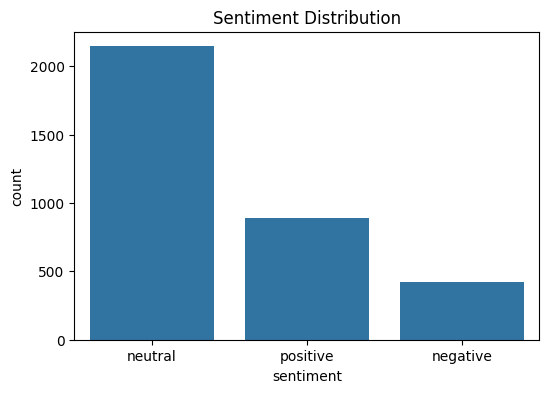

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_raw, x="sentiment", order=df_raw["sentiment"].value_counts().index
)
plt.title("Sentiment Distribution")
plt.show()

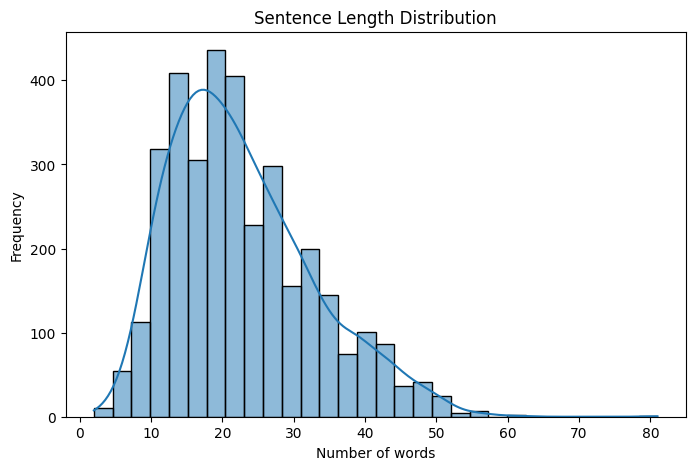

In [12]:
df_raw["text_length"] = df_raw["sentence"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df_raw["text_length"], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

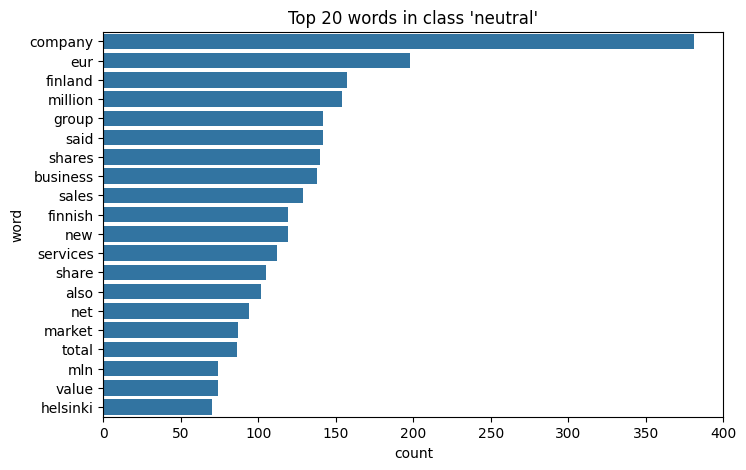

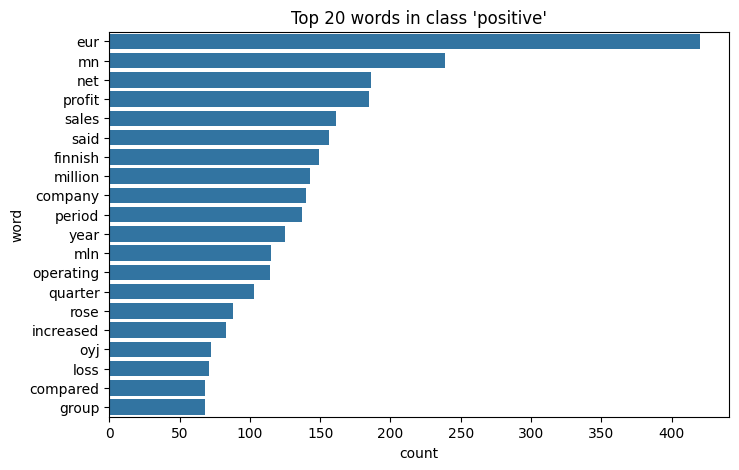

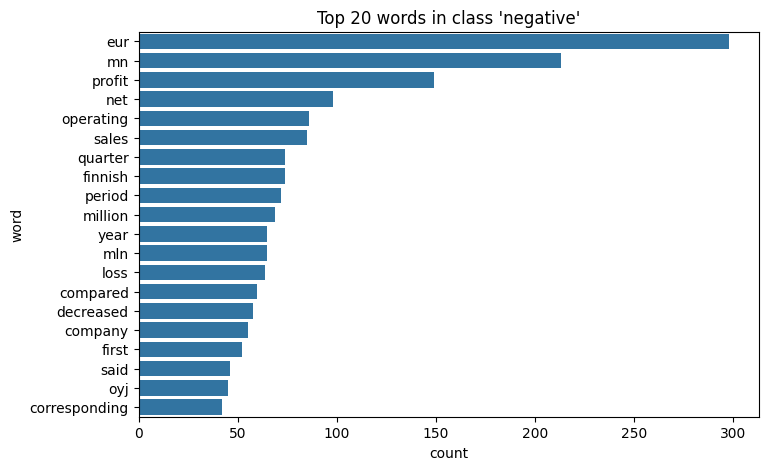

In [13]:
for label in df_raw["sentiment"].unique():
    top_words = get_top_words_by_label(df_raw, label)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=top_words, x="count", y="word")
    plt.title(f"Top 20 words in class '{label}'")
    plt.show()

### 4.6. Preprocessing

In [14]:
# Apply text cleaning
df_raw["clean_text"] = df_raw["sentence"].apply(clean_text)

# Assign numeric labels
df_raw["label"] = df_raw["sentiment"].map(LABEL_TO_ID)

# Train-eval split
train_df, eval_df = train_test_split(
    df_raw, test_size=0.2, stratify=df_raw["label"], random_state=42
)

### 4.7. Models

#### 4.7.1. Model 1: TF-IDF + Logistic Regression

##### Prepare data

In [15]:
X_train = train_df["clean_text"]
X_eval = eval_df["clean_text"]
y_train = train_df["label"]
y_eval = eval_df["label"]

##### TF-IDF Vectorization

In [16]:
vectorizer = TfidfVectorizer(max_features=10_000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_eval_vec = vectorizer.transform(X_eval)

##### Hyperparameter Tuning with Optuna

In [17]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e2, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "max_iter": 1_000,
        "multi_class": "ovr",
    }

    # Some combinations are invalid
    if params["penalty"] == "l1" and params["solver"] == "saga":
        pass  # válido
    elif params["penalty"] == "l1" and params["solver"] != "liblinear":
        raise optuna.exceptions.TrialPruned()

    model = OneVsRestClassifier(LogisticRegression(**params))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    with warnings.catch_warnings(action="ignore"):
        preds = cross_val_predict(
            model, X_train_vec, y_train, cv=skf, method="predict_proba"
        )

    roc = roc_auc_score(y_train, preds, multi_class="ovr")
    return roc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-23 11:45:30,623] A new study created in memory with name: no-name-3bd1f4bb-ca94-46e6-aff2-3ab0c8a4ee03
[I 2025-05-23 11:45:30,654] Trial 0 finished with value: 0.499063887242025 and parameters: {'C': 0.02675057691962885, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.499063887242025.
[I 2025-05-23 11:45:30,772] Trial 1 finished with value: 0.8239376018762691 and parameters: {'C': 0.024435074872442553, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.8239376018762691.
[I 2025-05-23 11:45:30,806] Trial 2 finished with value: 0.5004130399245041 and parameters: {'C': 0.0014927821669246792, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.8239376018762691.
[I 2025-05-23 11:45:30,954] Trial 3 finished with value: 0.8413634198148934 and parameters: {'C': 0.13807487310979294, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 3 with value: 0.8413634198148934.
[I 2025-05-23 11:46:30,101] Trial 4 finished with value: 0.890885649

##### Training best model

In [18]:
best_params = study.best_params
best_params["max_iter"] = 1_000
best_params["multi_class"] = "ovr"

logreg = OneVsRestClassifier(LogisticRegression(**best_params))
logreg.fit(X_train_vec, y_train)

c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression(C=23.1255548210185,
                                                 max_iter=1000,
                                                 multi_class='ovr',
                                                 solver='liblinear'))

##### Run predictions on the evaluation set

In [19]:
y_pred = logreg.predict(X_eval_vec)
y_prob = logreg.predict_proba(X_eval_vec)

##### Evaluate results

In [20]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.48      0.58        84
           1       0.84      0.95      0.89       429
           2       0.79      0.68      0.73       178

    accuracy                           0.82       691
   macro avg       0.79      0.70      0.73       691
weighted avg       0.82      0.82      0.81       691



In [21]:
logreg_metrics = classification_metrics(y_eval, y_pred, y_prob)
df_logreg_metrics = pd.DataFrame.from_dict(
    logreg_metrics, orient="index", columns=["scores"]
)
print(df_logreg_metrics)

                 scores
accuracy       0.823444
precision      0.790392
recall         0.702338
f1_score       0.813726
roc_auc        0.925035
avg_precision  0.848841


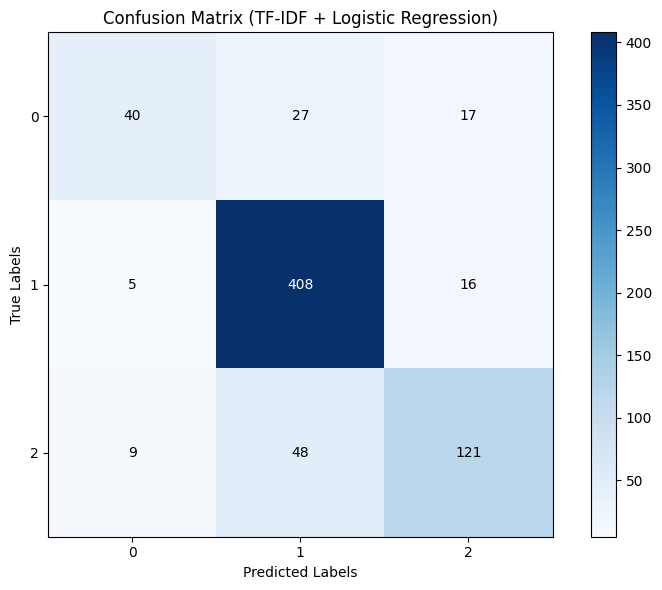

In [22]:
fig = ConfusionMatrixFigure.create_figure(
    y_true=y_eval,
    y_pred=y_pred,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Confusion Matrix (TF-IDF + Logistic Regression)",
)
plt.show()

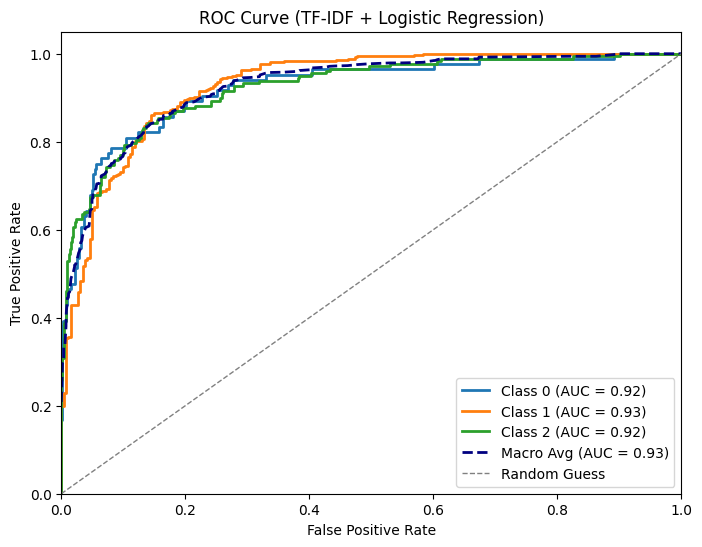

In [23]:
fig = RocAucFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="ROC Curve (TF-IDF + Logistic Regression)",
)
plt.show()

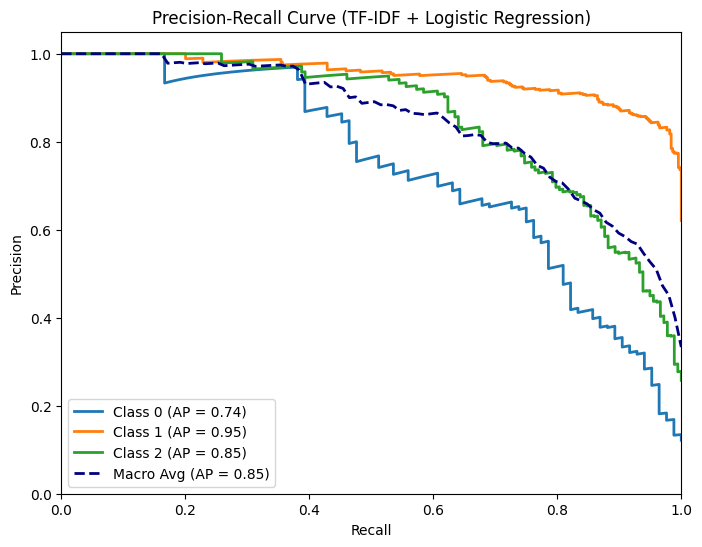

In [24]:
fig = PrecisionRecallFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Precision-Recall Curve (TF-IDF + Logistic Regression)",
)
plt.show()

#### 4.7.2. Model 2: TF-IDF + XGBoost

##### Prepare data

In [25]:
X_train = train_df["clean_text"]
X_eval = eval_df["clean_text"]
y_train = train_df["label"]
y_eval = eval_df["label"]

##### TF-IDF Vectorization

In [26]:
vectorizer = TfidfVectorizer(max_features=10_000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_eval_vec = vectorizer.transform(X_eval)

##### Hyperparameter Tuning with Optuna

In [27]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eval_metric": "mlogloss",
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    preds = cross_val_predict(
        model, X_train_vec, y_train, cv=skf, method="predict_proba"
    )
    roc = roc_auc_score(y_train, preds, multi_class="ovr")
    return roc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-23 11:46:36,122] A new study created in memory with name: no-name-a2ce688c-5e42-4be1-82a0-a729c9020daa
[I 2025-05-23 11:46:40,780] Trial 0 finished with value: 0.8726101021206345 and parameters: {'max_depth': 3, 'learning_rate': 0.10360162504994856, 'n_estimators': 192, 'subsample': 0.9433150291004075, 'colsample_bytree': 0.9135949107353653}. Best is trial 0 with value: 0.8726101021206345.
[I 2025-05-23 11:46:43,578] Trial 1 finished with value: 0.8699111541319683 and parameters: {'max_depth': 4, 'learning_rate': 0.2570240229254904, 'n_estimators': 125, 'subsample': 0.6722479466606117, 'colsample_bytree': 0.5217006673096103}. Best is trial 0 with value: 0.8726101021206345.
[I 2025-05-23 11:46:48,805] Trial 2 finished with value: 0.8766394424830665 and parameters: {'max_depth': 5, 'learning_rate': 0.11122495566388324, 'n_estimators': 189, 'subsample': 0.9504804413373129, 'colsample_bytree': 0.6144486998070712}. Best is trial 2 with value: 0.8766394424830665.
[I 2025-05-23 11:

##### Training best model

In [28]:
best_params = study.best_params
best_params["eval_metric"] = "mlogloss"

xgb = XGBClassifier(**best_params)
xgb.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7082243561497016, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16798932479035983,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=148, n_jobs=None,
              num_parallel_tree=None, ...)

##### Run predictions on the evaluation set

In [29]:
y_pred = xgb.predict(X_eval_vec)
y_prob = xgb.predict_proba(X_eval_vec)

##### Evaluate results

In [30]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.52      0.64        84
           1       0.82      0.97      0.89       429
           2       0.83      0.60      0.69       178

    accuracy                           0.82       691
   macro avg       0.82      0.70      0.74       691
weighted avg       0.82      0.82      0.81       691



In [31]:
xgb_metrics = classification_metrics(y_eval, y_pred, y_prob)
df_xgb_metrics = pd.DataFrame.from_dict(
    xgb_metrics, orient="index", columns=["scores"]
)
print(df_xgb_metrics)

                 scores
accuracy       0.821997
precision      0.821386
recall         0.697891
f1_score       0.809313
roc_auc        0.900472
avg_precision  0.814590


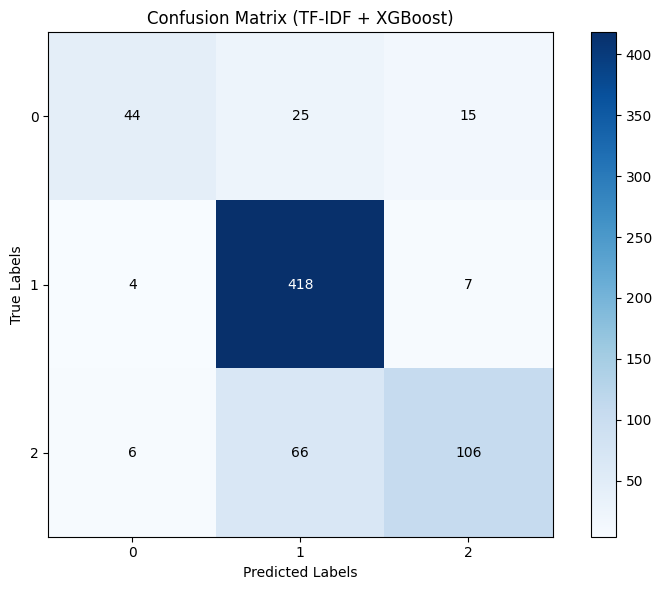

In [32]:
fig = ConfusionMatrixFigure.create_figure(
    y_true=y_eval,
    y_pred=y_pred,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Confusion Matrix (TF-IDF + XGBoost)",
)
plt.show()

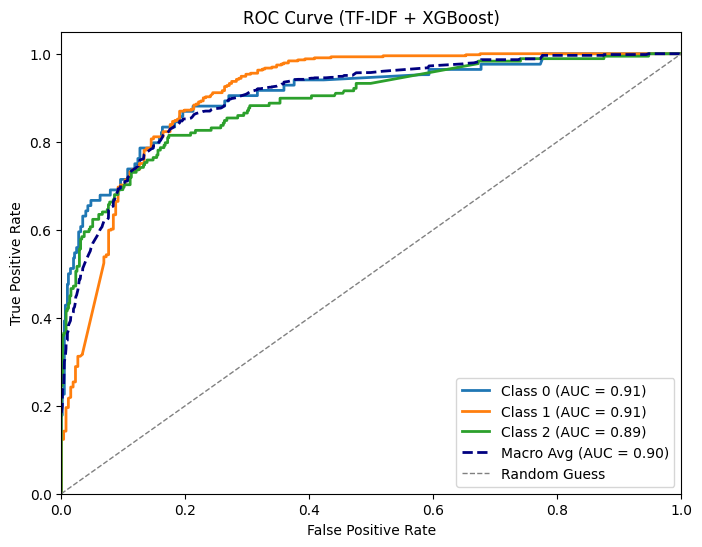

In [33]:
fig = RocAucFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="ROC Curve (TF-IDF + XGBoost)",
)
plt.show()

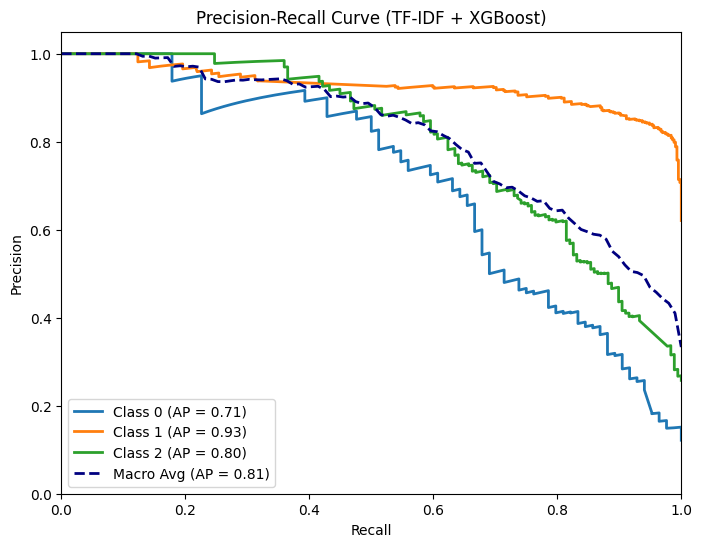

In [34]:
fig = PrecisionRecallFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Precision-Recall Curve (TF-IDF + XGBoost)",
)
plt.show()

#### 4.7.3. Model 3: Zero-shot with LLM (HuggingFace)

##### Prepare data

In [35]:
X_train = train_df["sentence"]
X_eval = eval_df["sentence"]
y_train = train_df["label"]
y_eval = eval_df["label"]

##### Load a pre-trained transformer for zero-shot classification

In [36]:
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

device = 0 if torch.cuda.is_available() else -1
zero_shot_classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=device,
    task="zero-shot-classification",
)

Device set to use cpu
c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


##### Run zero-shot classification on the evaluation set

In [37]:
sentences = X_eval.tolist()
batch_size = 32

y_pred = []
y_prob = []

for i in range(0, len(sentences), batch_size):
    batch = sentences[i : i + batch_size]
    outputs = zero_shot_classifier(batch)

    for probs in outputs:
        scores = [s["score"] for s in probs]
        y_prob.append(scores)
        y_pred.append(int(np.argmax(scores)))

y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

##### Evaluate results

In [38]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42        84
           1       0.69      0.90      0.78       429
           2       0.64      0.35      0.46       178

    accuracy                           0.69       691
   macro avg       0.70      0.51      0.55       691
weighted avg       0.69      0.69      0.65       691



In [39]:
zero_shot_metrics = classification_metrics(y_eval, y_pred, y_prob)
df_zero_shot_metrics = pd.DataFrame.from_dict(
    zero_shot_metrics, orient="index", columns=["scores"]
)
print(df_zero_shot_metrics)

                 scores
accuracy       0.687410
precision      0.702481
recall         0.514692
f1_score       0.654485
roc_auc        0.897817
avg_precision  0.781149


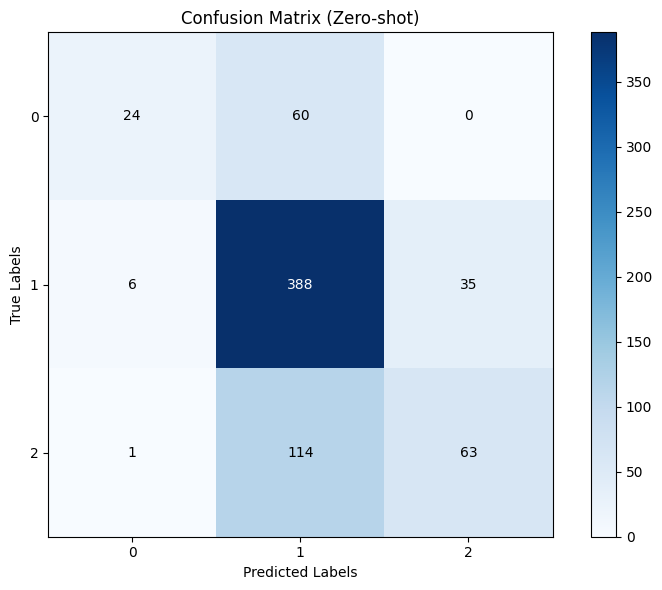

In [40]:
fig = ConfusionMatrixFigure.create_figure(
    y_true=y_eval,
    y_pred=y_pred,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Confusion Matrix (Zero-shot)",
)
plt.show()

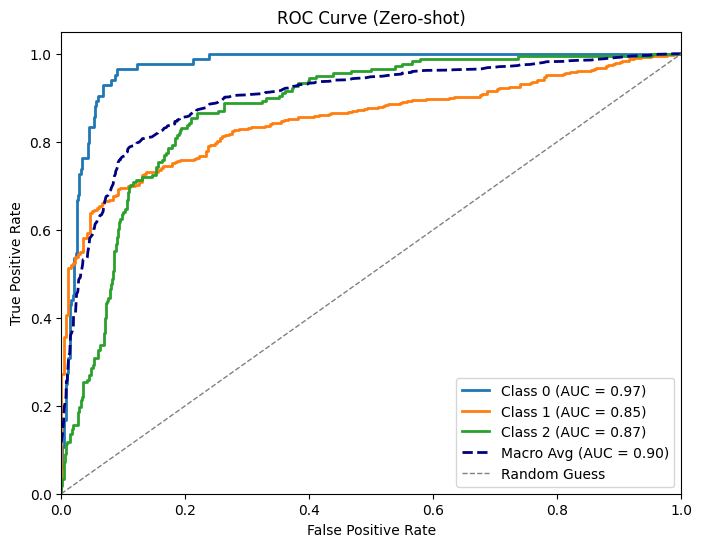

In [41]:
fig = RocAucFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="ROC Curve (Zero-shot)",
)
plt.show()

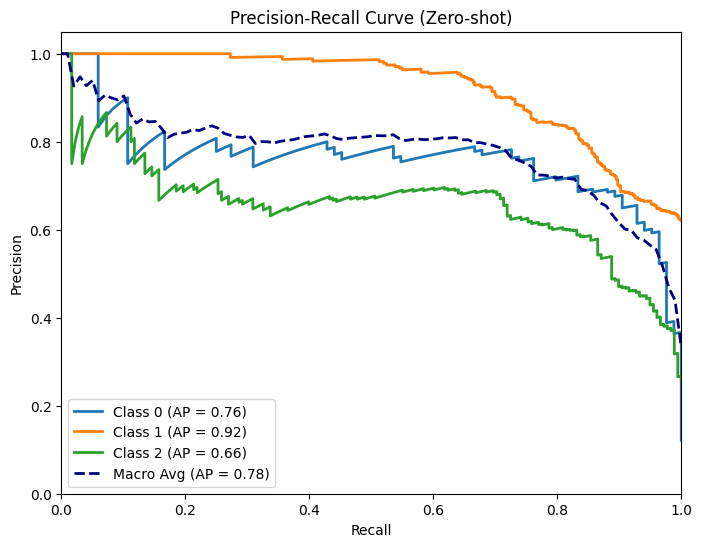

In [42]:
fig = PrecisionRecallFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Precision-Recall Curve (Zero-shot)",
)
plt.show()

#### 4.7.4. Model 4: Fine-tuned LLM using PEFT + LoRA

##### Prepare data

In [43]:
X_train = train_df["sentence"]
X_eval = eval_df["sentence"]
y_train = train_df["label"]
y_eval = eval_df["label"]

##### Load tokenizer and base model for fine-tuning

In [44]:
checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

##### Split train / test

In [45]:
df_train = pd.DataFrame({"text": X_train, "label": y_train})
dataset = Dataset.from_pandas(df_train)


def tokenize(example):
    return tokenizer(example["text"], truncation=True)


tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.train_test_split(test_size=0.1)
train_ds = tokenized["train"]
eval_ds = tokenized["test"]

Map: 100%|██████████| 2762/2762 [00:00<00:00, 18006.82 examples/s]


##### Prepare model for parameter-efficient fine-tuning

In [46]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3
)
base_model.gradient_checkpointing_enable()
base_model = prepare_model_for_kbit_training(base_model)

##### Define LoRA configuration

In [47]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)
peft_model = get_peft_model(base_model, peft_config)

##### Define training arguments

In [48]:
training_args = TrainingArguments(
    output_dir="./qlora_model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-4,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    fp16=True,
    metric_for_best_model="accuracy",
)

##### Define trainer

In [49]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)


trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\digiovanni\AppData\Local\Temp\ipykernel_16940\36067580.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


##### Train model

In [50]:
trainer.train()

c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.443300
100,0.209500
150,0.250000
200,0.198800
250,0.166600
300,0.148200
350,0.158600
400,0.137600
450,0.111100


c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\code\adigiovanni\DowJones\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=468, training_loss=0.19868901703092787, metrics={'train_runtime': 535.8184, 'train_samples_per_second': 13.913, 'train_steps_per_second': 0.873, 'total_flos': 228422126642580.0, 'train_loss': 0.19868901703092787, 'epoch': 3.0})

##### Make predictions

In [51]:
# Manually tokenize the evaluation set
eval_encodings = tokenizer(
    list(X_eval), truncation=True, padding=True, return_tensors="pt"
)

# Move tensors to the same device as the model
eval_encodings = {k: v.to(model.device) for k, v in eval_encodings.items()}

model = trainer.model
model.eval()

# Disable gradient calculation
with torch.no_grad():
    outputs = model(**eval_encodings)
    logits = outputs.logits
    y_prob = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    y_pred = np.argmax(y_prob, axis=1)

##### Evaluate results

In [52]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        84
           1       0.97      0.95      0.96       429
           2       0.89      0.93      0.91       178

    accuracy                           0.94       691
   macro avg       0.93      0.94      0.93       691
weighted avg       0.94      0.94      0.94       691



In [53]:
fine_tuning_metrics = classification_metrics(y_eval, y_pred, y_prob)
df_fine_tuning_metrics = pd.DataFrame.from_dict(
    fine_tuning_metrics, orient="index", columns=["scores"]
)
print(df_fine_tuning_metrics.head(10))

                 scores
accuracy       0.942113
precision      0.926515
recall         0.938720
f1_score       0.942407
roc_auc        0.992097
avg_precision  0.985551


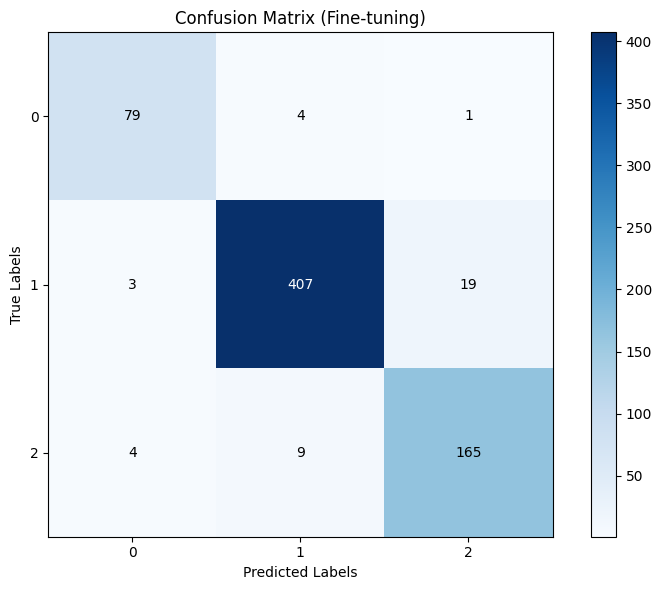

In [54]:
fig = ConfusionMatrixFigure.create_figure(
    y_true=y_eval,
    y_pred=y_pred,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Confusion Matrix (Fine-tuning)",
)
plt.show()

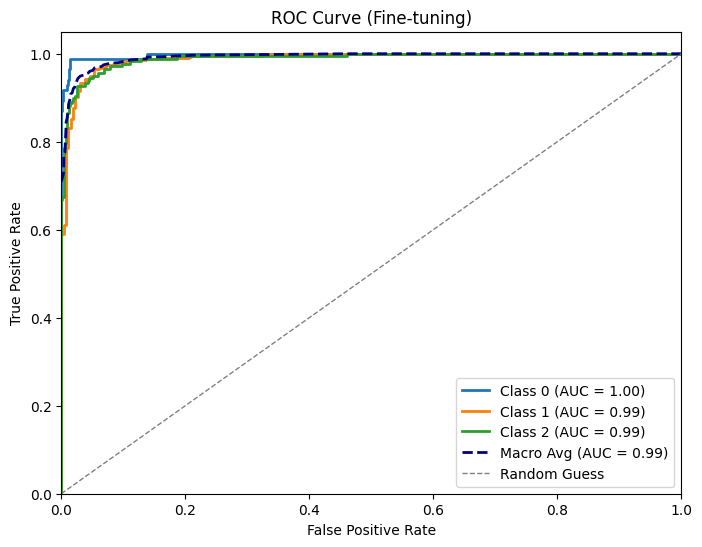

In [55]:
fig = RocAucFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="ROC Curve (Fine-tuning)",
)
plt.show()

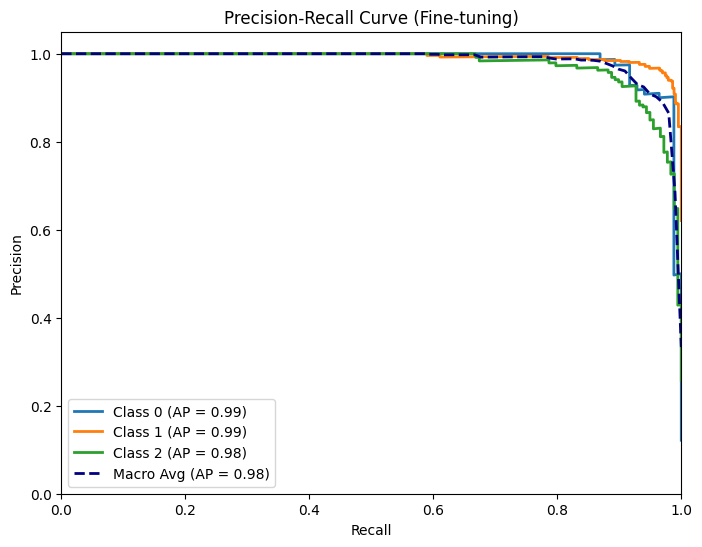

In [56]:
fig = PrecisionRecallFigure.create_figure(
    y_true=y_eval,
    y_prob=y_prob,
    model_classes=np.arange(len(LABEL_TO_ID)),
    title="Precision-Recall Curve (Fine-tuning)",
)
plt.show()

##### Misclassified Examples

In [57]:
y_true = y_eval.reset_index(drop=True)
y_pred_labels = y_pred

df_errors = pd.DataFrame({
    "Text": X_eval.reset_index(drop=True),
    "True Label": y_true,
    "Predicted Label": y_pred_labels
})

df_misclassified = df_errors[df_errors["True Label"] != df_errors["Predicted Label"]]
sample_errors = df_misclassified.sample(3, random_state=42)

explainer = SequenceClassificationExplainer(model, tokenizer)

for i, (_, row) in enumerate(sample_errors.iterrows()):
    print("="*20, f"Example {i + 1}", "="*20)
    print(f"Text:\n{row['Text']}\n")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    word_attributions = explainer(row['Text'])
    explainer.visualize()

==================== Example 1 ====================
Text:
shock phase ' , consumers have once again started to plan and implement building projects .

True Label: 1
Predicted Label: 2


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_2 (0.79),LABEL_2,1.47,"#s shock phase ' , consumers have once again started to plan and implement building projects . #/s"


==================== Example 2 ====================
Text:
According to Kesko , the company agreed with the city administration about lease of the building in 2006 , its resettlement and construction of a five-star hotel Hilton for 120 rooms .

True Label: 2
Predicted Label: 1


==================== Example 3 ====================
Text:
For Telenor , the three and a half year contract is worth an estimated 12.6 m. YIT has chosen Telenor and Elisa as its principal suppliers of ICT solutions in Norway , Sweden , Denmark and Finland .

True Label: 2
Predicted Label: 1


## 5. Evaluation

In [58]:
def compare_models(metrics_dict):
    df_compare = pd.DataFrame(metrics_dict).T
    df_compare = df_compare[
        ["accuracy", "precision", "recall", "f1_score", "roc_auc", "avg_precision"]
    ]
    df_compare.index.name = "Model"
    return df_compare


metrics_dict = {
    "TF-IDF + Logistic Regression": logreg_metrics,
    "TF-IDF + XGBoost": xgb_metrics,
    "Zero-shot LLM": zero_shot_metrics,
    "Fine-tuned LLM": fine_tuning_metrics,
}

df_compare = compare_models(metrics_dict)
print("\nModel Comparison:\n")
print(df_compare)


Model Comparison:

                              accuracy  precision    recall  f1_score  \
Model                                                                   
TF-IDF + Logistic Regression  0.823444   0.790392  0.702338  0.813726   
TF-IDF + XGBoost              0.821997   0.821386  0.697891  0.809313   
Zero-shot LLM                 0.687410   0.702481  0.514692  0.654485   
Fine-tuned LLM                0.942113   0.926515  0.938720  0.942407   

                               roc_auc  avg_precision  
Model                                                  
TF-IDF + Logistic Regression  0.925035       0.848841  
TF-IDF + XGBoost              0.900472       0.814590  
Zero-shot LLM                 0.897817       0.781149  
Fine-tuned LLM                0.992097       0.985551  


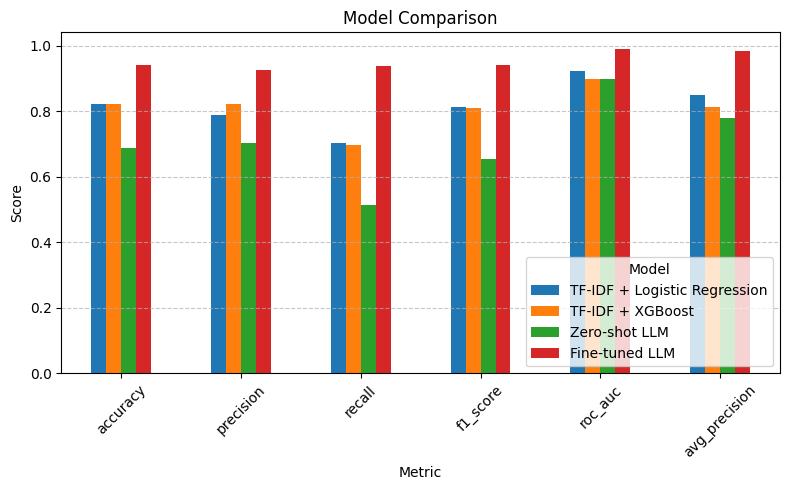

In [59]:
df_compare.T.plot(kind="bar", figsize=(8, 5))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Model", loc="lower right")
plt.tight_layout()
plt.show()

The results reveal a clear trend: performance improves notably with the use of more sophisticated and domain-adapted models.

**Key Observations**

* The **Fine-tuned LLM** (`cardiffnlp/twitter-roberta-base-sentiment`) **achieves the best overall performance**, with an F1-score of **0.94**, ROC-AUC of **0.99**, and accuracy above **94%**. This underscores the advantage of fine-tuning on task-specific, domain-relevant data—especially in finance, where subtle language cues can influence interpretation.

* **Logistic Regression with TF-IDF** performs remarkably well considering its simplicity, with an F1-score of **0.81** and a ROC-AUC of **0.93**. It demonstrates that with a well-engineered feature representation (TF-IDF), even linear models can offer strong baselines for structured text classification tasks.

* **XGBoost**, while competitive, shows a slightly **lower recall** (0.698) compared to Logistic Regression, suggesting it may be more conservative in detecting minority classes, potentially leading to **higher false negatives**.

* The **Zero-shot LLM** underperforms across all metrics relative to the fine-tuned counterpart. While it maintains a respectable ROC-AUC (**0.89**) and average precision (**0.78**), its **low recall (0.51)** and **F1-score (0.65)** indicate that **general-purpose models struggle without task-specific fine-tuning**, especially in domains like finance that require nuanced language understanding.


**Strengths and Limitations**

*Strengths:*

* The pipeline supports a wide range of modeling approaches, making it easy to benchmark classical vs. deep learning methods.
* Fine-tuned models excel in capturing sentiment subtleties in financial language, confirming the importance of domain adaptation.
* The inclusion of interpretability tools (e.g., `transformers-interpret`) provides transparency into model behavior.

*Limitations:*

* Classical models, while fast and interpretable, may miss contextual signals crucial in financial language (e.g., sarcasm, negation).
* Zero-shot models lack grounding in domain data, which limits their predictive power without further adaptation.
* Fine-tuning LLMs is resource-intensive and may require substantial compute and labeled data for new domains.


## 6. Recommendations & Next Steps

**Recommendations and Future Work**

Based on the results and observed limitations, the following recommendations are proposed to enhance model performance, robustness, and applicability:

1. **Refinement of the Fine-Tuned LLM**

* Conduct **extensive hyperparameter tuning**, particularly on batch size, learning rate, and number of training epochs.
* Experiment with **larger or more domain-specific transformer models**, such as `FinBERT`, `DeBERTa-v3`, or `bert-large`, which may better capture the nuances of financial language.
* Investigate **training enhancements**, such as adversarial training, **mixup** techniques, or **data augmentation** using paraphrasing strategies tailored to financial text.

2. **Ensemble Modeling**

* Explore **ensemble methods** to combine the strengths of classical and transformer-based approaches:

  * Use **soft voting** or **stacking** with models like Logistic Regression and fine-tuned RoBERTa.
  * Ensembles may improve robustness and reduce variance, especially in edge cases or ambiguous inputs.

3. **Advanced Error Analysis**

* Perform **qualitative review of misclassified samples** to detect common failure patterns (e.g., negations, idioms, mixed signals).
* Consider **manual annotation of additional edge cases** or underrepresented constructs to enhance data diversity and fill semantic gaps.

4. **Model Interpretability**

* Use **LIME** or **SHAP** with classical models (e.g., Logistic Regression) to understand the most influential tokens and features.
* For transformer-based models, continue leveraging tools like **`transformers-interpret`** to visualize **attention scores** and decision boundaries for transparency and trust.

5. **Deployment and Production Readiness**

If operational deployment is considered:

* Convert the trained transformer model to **ONNX** or **TorchScript** to optimize inference speed and reduce memory footprint.
* Perform benchmarks on **latency and throughput**, especially for real-time applications like market monitoring.
* Implement **continuous evaluation and retraining pipelines** to incorporate new labeled financial data and adapt to changing language trends.

6. **Future Extensions**

* Develop modules for **temporal sentiment analysis**, enabling time-series modeling of sentiment shifts across companies or sectors.
* Use embeddings from the fine-tuned model to power a **semantic similarity engine**, supporting applications such as financial content recommendation, clustering, or anomaly detection.